# Лабораторная работа №2. 16 МАГ ИАД Мартиросян Алиса

Использованные языки:
    - English 
    - Gothic 
    
    
 ## Часть I: Установка и использование SyntaxNet
 
 Для установки SyntaxNet был выбран вариант с запуском Docker контейнера под Windows 10. Для этого был установлен Docker Version 17.09.1 и использован готовый образ от tensorflow: 
 
```
 docker pull tensorflow/syntaxnet
```
 
 Так же для правильной работы под Windows требовалось отключить ipV6 в настройках виртуального сетевого адаптера Docker и вручную прописать днс-порт. Далее контейнер стартовался командой:
 
```
 docker run -it -p 8888:8888 tensorflow/syntaxnet
```
 
 
 ## Прогон тестовых корпусов через SyntaxNet POS-tagger
 
 1. With SyntaxNet Pos-Tagger 
 Для прогона языком с помощью пос-теггера SyntaxNet был использован следующий скрипт parse_with_tagger.sh

```
cat /data/UD_English/en-ud-test.conllu | syntaxnet/parse_with_tagger.sh --conll /models/english/English > /output/eng-with-tagger.conll

cat /data/UD_Gothic/got-ud-test.conllu | syntaxnet/parse_with_tagger.sh --conll /models/gothic/Gothic > /output/go-with-tagger.conll
```

2. Without SyntaxNet Pos-Tagger 
 Для прогона языком с помощью пос-теггера SyntaxNet был использован следующий скрипт parse_without_tagger.sh
 
 ```
  cat /data/UD_English/en-ud-test.conllu | syntaxnet/parse_without_tagger.sh --conll /models/english/English > /output/eng-wo-tagger.conll
  cat /data/UD_Gothic/got-ud-test.conllu | syntaxnet/parse_without_tagger.sh --conll /models/gothic/Gothic > /output/go-wo-tagger.conll
```
  

## English language 

### Морфологический тип языка: 

Флективный - основной грамматический способ – аффиксация, причём использование не только внешней, но и внутренней флексии; флексии многозначны.

### Accuracy (POS) :

```
INFO:tensorflow:Total processed documents: 2077
INFO:tensorflow:num correct tokens: 19976
INFO:tensorflow:total tokens: 25096
INFO:tensorflow:Seconds elapsed in evaluation: 78.43, eval metric: 79.60%
```

In [5]:
import os
import os.path
import urllib
from zipfile import ZipFile
import sys
import nltk
import math
import time
import collections
import itertools
from itertools import cycle, islice
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIR = '/output'

def read_sents(path_to_file):
    TO_SKIP = ('#')
    EOL = '\n'
    with open(path_to_file, 'r') as f:
        sentences = []
        sentence = []
        for line in f.readlines():
            line = line.strip().decode('utf-8')
            if line.startswith(TO_SKIP):
                # This is likely to be a comment
                continue
            elif len(line) < 1:
                # Sentence is over
                if sentence is not None and len(sentence):
                    sentences.append(EOL.join(sentence))
                    sentence = []
            else:
                # Store line to sentence
                sentence.append(line)
        return sentences
            
def calc_las_and_uas(path_to_predicted_file, path_to_gold_file):
    gold_sents = [nltk.parse.DependencyGraph(s) for s in read_sents(path_to_gold_file)]
    parsed_sents = [nltk.parse.DependencyGraph(s) for s in read_sents(path_to_predicted_file)]
    de = nltk.parse.DependencyEvaluator(parsed_sents, gold_sents)
    return de.eval() 



## English LAS и UAS

In [78]:
gold_file = '/data/UD_English/en-ud-test.conllu'
parsed_file = '/output/english/en-with-tagger.conll'
las, uas = calc_las_and_uas(parsed_file, gold_file)
print('LAS: {}, UAS: {}'.format(las, uas))

LAS: 0.811147062845, UAS: 0.580276170077


### Часть II: языковая статистика по результатам прогона SyntaxNet

In [34]:
import sys
import nltk
import math
import time
import collections
import itertools
from itertools import cycle, islice
import math
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import io
%matplotlib inline

TAB_CHAR = '\t'
EQ_SIGN_CHAR = '='
PIPE_CHAR = '|'

BINARY_ATTRIBUTES = ['Abbr', 'Foreign', 'Poss', 'Reflex']
CATEGORICAL_ATTRIBUTES = ['Animacy', 'Aspect', 'Case', 'Definite', 'Degree', 'Evident', 'Gender', 'Mood',\
                          'NumType', 'Number', 'Person', 'Polarity', 'Polite', 'PronType', 'Tense',\
                          'VerbForm', 'Voice']

FOREIGN_ATTR = 'Foreign'
YES_WORD = 'Yes'

def parse_conll(conll):
   with open(conll, 'r') as f:
        lines = f.readlines()
        tag_count = collections.defaultdict(int)
        attr_count = collections.defaultdict(int)
        dep_count = collections.defaultdict(int)
        word_count = collections.defaultdict(int)
        all_tokens_count = 0
        for line in lines:
            splitted_line = line.split(TAB_CHAR)
            word_index = splitted_line[0]

            if word_index.isdigit():
                word = splitted_line[1]
                word_count[word] += 1
                all_tokens_count += 1
                pos = splitted_line[3]
                tag_count[pos] += 1

                attributes = splitted_line[5]
                for attr in BINARY_ATTRIBUTES:
                    index = attributes.find(attr)
                    if index > -1:
                        index += len(attr) + 1
                        nstring = ''
                        if attr != FOREIGN_ATTR:
                            nstring = attributes[index:index+len(YES_WORD)]
                        else:
                            nstring = attributes[index:index+len(FOREIGN_ATTR)]
                        if nstring == YES_WORD or nstring == FOREIGN_ATTR:
                            attr_count[attr] += 1
                for attr in CATEGORICAL_ATTRIBUTES:
                    index = attributes.find(attr)
                    if index != -1:
                        index += len(attr)
                        cut_string = attributes[index:]
                        index_start = cut_string.find(EQ_SIGN_CHAR)
                        index_start += 1 # =
                        index_end = cut_string.find(PIPE_CHAR)
                        if index_end == -1:
                            index_end = cut_string.find(TAB_CHAR)
                        if index_end != -1:
                            value = cut_string[index_start:index_end]
                            attr_name = attr + ':' + value
                            attr_count[attr_name] += 1

                dep = splitted_line[7]
                dep_count[dep] += 1 

        return all_tokens_count, word_count, tag_count, attr_count, dep_count

In [44]:
def pos_stat(tag_count):
    df = pd.DataFrame([(lambda tag, count: {'PoS':tag, 'Count':count})(tag, count) for tag, count in tag_count.items()])
    df['CountNormalize'] = df.Count.apply(lambda x : float(x)/sum(df.Count))
    df = df[['PoS', 'Count','CountNormalize']]
    return df.sort_values('CountNormalize', ascending=False)

def pos_plot(pos_stat_data):
    pos_stat_data.plot(x='PoS', y='CountNormalize', kind='bar', grid=True, figsize=(10,6), legend=False)
    plt.show()
   

def attr_stat(attr_count):
    attrs = []
    counts = []
    norms = []
    for attr, count in attr_count.items():
        attrs.append(attr)
        counts.append(count)
    table = pd.DataFrame(data={'Attribute' : attrs, 'Count' : counts})
    for i in counts:
        norms.append(float(i) / sum(table.Count))
    table['Norm'] = norms
    table = table[['Attribute', 'Count','Norm']]
    return table

def dep_stat(dep_count):
    deps = []
    counts = []
    norms = []
    for dep, count in dep_count.items():
        deps.append(dep)
        counts.append(count)
    table = pd.DataFrame(data={'Dep' : deps, 'Count' : counts})
    for i in counts:
        norms.append(float(i) / sum(table.Count))
    table['Norm'] = norms
    table = table[['Dep', 'Count','Norm']]
    return table


def show_plot(data, column, title):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'black', 'orange', 'purple', 'gray']), None, len(data)))
    data.plot(x=column, y='Norm', kind='bar', figsize=(5, 5), grid=True, title=title, legend=False, color=my_colors)
    plt.show()

In [45]:

en_train = '/data/UD_English/en-ud-test.conllu'
en_test ='/data/UD_English/en-ud-train.conllu'

# Info for train data
en_train_token_count, en_train_word_count, en_train_tag_count, en_train_attr_count, en_train_dep_count = \
                                                                parse_conll(en_train)
# Info for test data
en_test_token_count, en_test_word_count, en_test_tag_count, en_test_attr_count, en_test_dep_count = \
                                                            parse_conll(en_test)

## English Pos-Tag Statistic (train)

In [97]:
en_train_stat = pos_stat(en_train_tag_count)
en_train_stat


,PoS,Count,CountNormalize
1,NOUN,4133,0.164688
4,PUNCT,3106,0.123765
12,VERB,2653,0.105714
11,PRON,2158,0.085990
6,PROPN,2076,0.082722
3,ADP,2019,0.080451
7,DET,1896,0.075550
16,ADJ,1692,0.067421
15,AUX,1496,0.059611
0,ADV,1226,0.048852


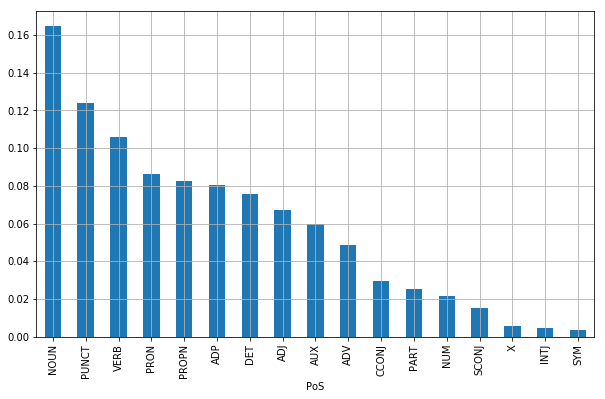

In [98]:
pos_plot(en_train_stat)

## English Pos-Tag Statistic (test)

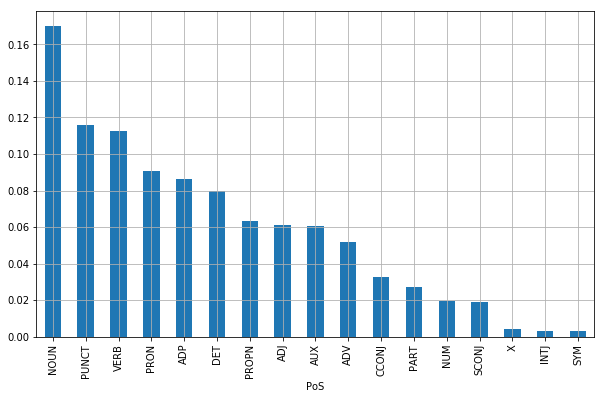

In [48]:
en_test_stat = pos_stat(en_test_tag_count)
en_test_stat
pos_plot(en_test_stat)

## English Binary attribute Statistic (train)

In [60]:
def bar_plot(data, column, title):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k', 'black', 'orange', 'purple', 'gray']), None, len(data)))
    data.plot(x=column, y='Norm', kind='bar', figsize=(5, 5), grid=True, title=title, legend=False, color=my_colors)
    plt.show()

def binary_attr_plot(attr_count):
    binary_stat = {}
    for attr in BINARY_ATTRIBUTES:
        for k,v in attr_count.items():
            if k.find(attr) != -1:
                binary_stat[attr] = v 
    df = attr_stat(binary_stat)
    print(df)
    bar_plot(df, 'Attribute', 'Binary')
    
    

  Attribute  Count      Norm
0    Reflex      4  0.012085
1      Poss    318  0.960725
2   Foreign      9  0.027190


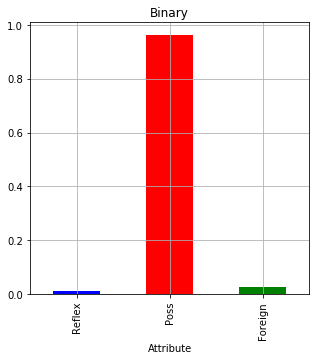

In [61]:
binary_attr_plot(en_train_attr_count)

## English Binary attribute Statistic (test)

  Attribute  Count      Norm
0    Reflex    100  0.031807
1      Poss   3026  0.962468
2   Foreign     18  0.005725


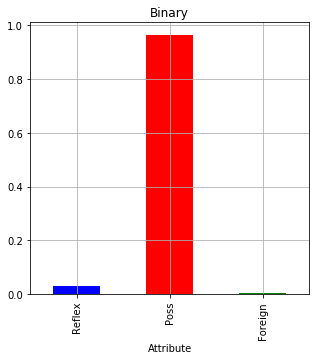

In [62]:
binary_attr_plot(en_test_attr_count)

## English Categorical attribute Statistic (train)

In [63]:
def categorical_attr_plot(attr_count):
    attr_only_spec = {}
    for attr in CATEGORICAL_ATTRIBUTES:
        spec_dict = {}
        for k,v in attr_count.items():
            if k.find(attr) != -1:
                new_key = k[k.find(':')+1:]
                spec_dict[new_key] = v
        if len(spec_dict) > 1:
            attr_only_spec[attr] = spec_dict
    for k,v in attr_only_spec.items():  
        df = attr_stat(attr_only_spec[k])
        print(k)
        print(df)
        bar_plot(df, 'Attribute', k)

Case
  Attribute  Count      Norm
0       Acc    264  0.186047
1       Nom   1155  0.813953


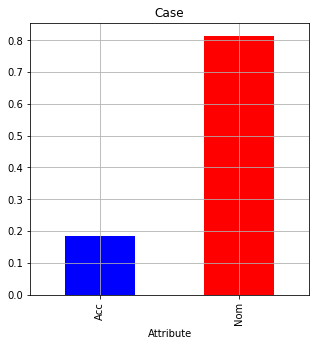

Mood
  Attribute  Count      Norm
0       Ind   1826  0.914372
1       Imp    171  0.085628


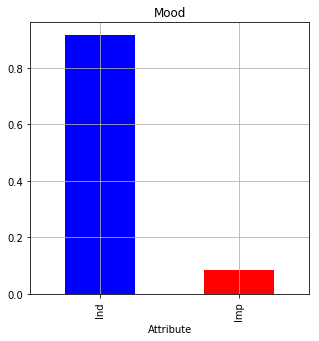

Gender
  Attribute  Count      Norm
0      Neut    223  0.579221
1       Fem     40  0.103896
2      Masc    122  0.316883


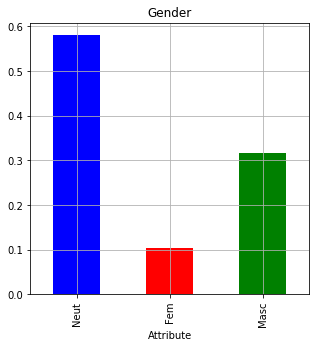

Definite
  Attribute  Count     Norm
0       Ind    565  0.36736
1       Def    973  0.63264


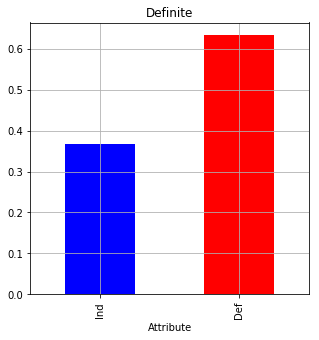

Number
  Attribute  Count      Norm
0      Sing   1951  0.836621
1      Plur    381  0.163379


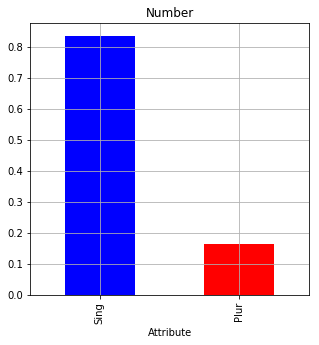

Person
  Attribute  Count      Norm
0         1    861  0.350999
1         3   1237  0.504280
2         2    355  0.144721


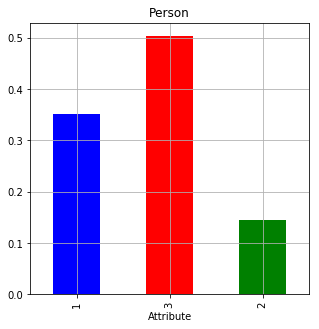

Tense
  Attribute  Count      Norm
0      Past    981  0.414624
1      Pres   1385  0.585376


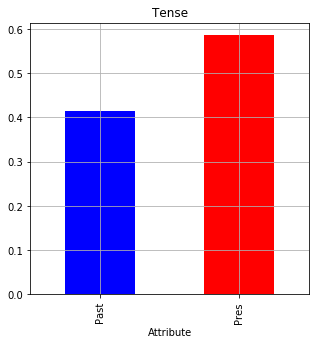

In [64]:
categorical_attr_plot(en_train_attr_count)

## English Categorical attribute Statistic (test)

Case
  Attribute  Count      Norm
0       Acc   2622  0.217179
1       Nom   9451  0.782821


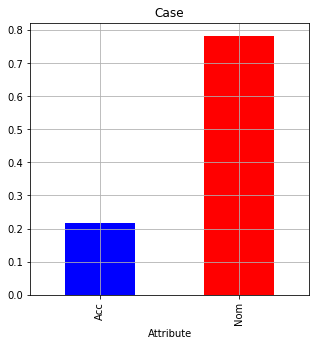

Mood
  Attribute  Count      Norm
0       Ind  15344  0.927298
1       Imp   1203  0.072702


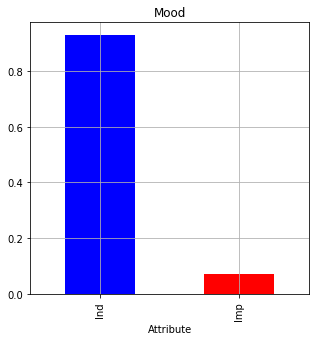

Gender
  Attribute  Count      Norm
0      Neut   2022  0.501364
1       Fem    491  0.121746
2      Masc   1520  0.376891


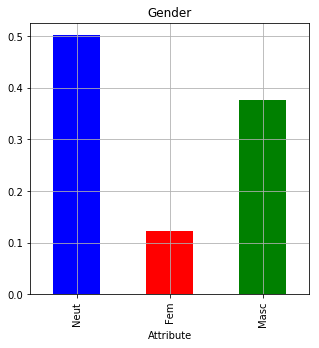

Definite
  Attribute  Count      Norm
0       Ind   4236  0.318496
1       Def   9064  0.681504


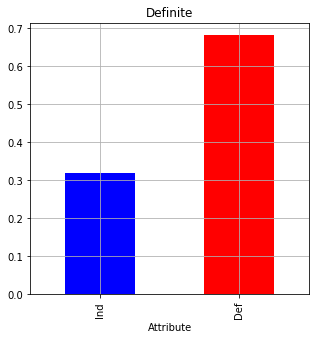

Number
  Attribute  Count      Norm
0      Sing  16615  0.819361
1      Plur   3663  0.180639


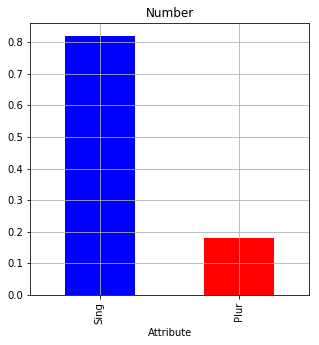

Person
  Attribute  Count      Norm
0         1   6657  0.314692
1         3  11643  0.550392
2         2   2854  0.134915


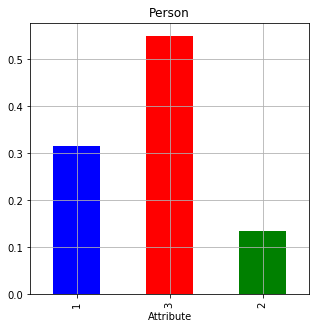

Tense
  Attribute  Count      Norm
0      Past   9359  0.462584
1      Pres  10873  0.537416


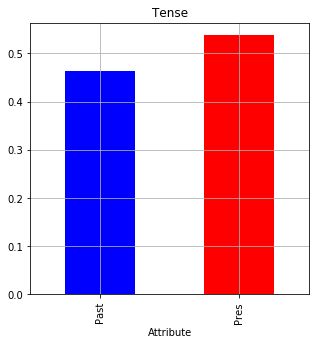

In [65]:
categorical_attr_plot(en_test_attr_count)

## English Universal Dependency Statistic (train)

In [72]:
def universal_dep_stat(dep_count):
    df = pd.DataFrame([(lambda dep, count: {'Dep':dep, 'Count':count})(dep, count) for dep, count in dep_count.items()])
    df['Norm'] = df.Count.apply(lambda x : float(x)/sum(df.Count))
    df = df[['Dep', 'Count','Norm']]
    return df.sort_values('Norm', ascending=False)

def universal_dep_plot(dep_count):
    dep_count.plot(x='Dep', y='Norm', kind='bar', figsize=(12, 6), legend=False, grid=True)
    plt.show()

In [73]:
en_train_dep = universal_dep_stat(en_train_dep_count)
en_train_dep

,Dep,Count,Norm
27,punct,3068,0.122251
46,root,2077,0.082762
32,case,1979,0.078857
21,nsubj,1975,0.078698
38,det,1831,0.072960
24,advmod,1283,0.051124
35,obj,1179,0.046980
41,amod,1173,0.046741
28,compound,1152,0.045904
34,obl,1055,0.042039


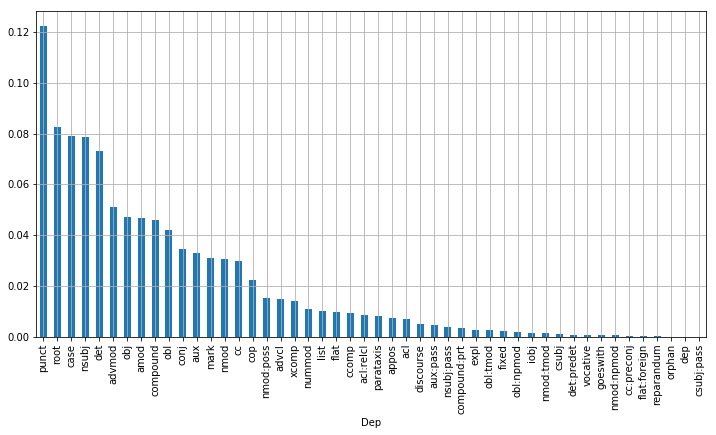

In [74]:
universal_dep_plot(en_train_dep)

## English Universal Dependency Statistic (test)¶

In [76]:
en_test_dep = universal_dep_stat(en_test_dep_count)
en_test_dep

,Dep,Count,Norm
28,punct,23596,0.115336
33,case,17448,0.085285
22,nsubj,16256,0.079458
39,det,15753,0.077000
47,root,12543,0.061309
25,advmod,10947,0.053508
36,obj,10189,0.049803
35,obl,9155,0.044749
42,amod,9062,0.044295
29,compound,8204,0.040101


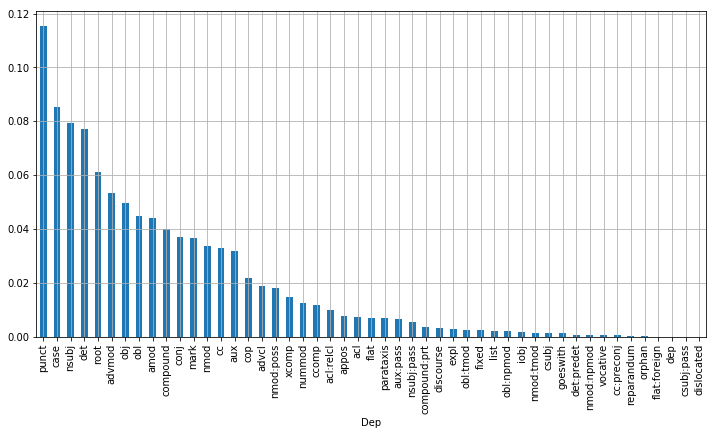

In [77]:
universal_dep_plot(en_test_dep)

### Gothic language

Морфологический тип: 
Флективный - основной грамматический способ – аффиксация, причём использование не только внешней, но и внутренней флексии; флексии многозначны.

Accuracy (POS) :
```
INFO:tensorflow:num correct tokens: 9392
INFO:tensorflow:total tokens: 10182
INFO:tensorflow:Seconds elapsed in evaluation: 34.26, eval metric: 92.24%
```

### Gothic LAS and UAS

In [80]:
gold_file = '/data/UD_Gothic/got-ud-test.conllu'
parsed_file = '/output/go-with-tagger.conll'
las, uas = calc_las_and_uas(parsed_file, gold_file)
print('LAS: {}, UAS: {}'.format(las, uas))

LAS: 0.922412099784, UAS: 0.62639952858


### Часть II: языковая статистика по результатам прогона SyntaxNet

In [83]:
got_train = '/data/UD_Gothic/got-ud-test.conllu'
got_test ='/data/UD_Gothic/got-ud-train.conllu'

# Info for train data
got_train_token_count, got_train_word_count, got_train_tag_count, got_train_attr_count, got_train_dep_count =parse_conll(got_train)
# Info for test data
got_test_token_count, got_test_word_count, got_test_tag_count, got_test_attr_count, got_test_dep_count = parse_conll(got_test)

## Gothic Pos-Tag Statistic (train)

In [85]:
got_train_stat = pos_stat(got_train_tag_count)
got_train_stat

,PoS,Count,CountNormalize
8,VERB,2451,0.240719
1,NOUN,1799,0.176684
7,PRON,1106,0.108623
0,ADV,957,0.093989
11,CCONJ,931,0.091436
2,ADP,863,0.084757
13,ADJ,794,0.077981
5,DET,479,0.047044
4,PROPN,352,0.034571
3,SCONJ,289,0.028383


## Gothic Pos-Tag Statistic (train)

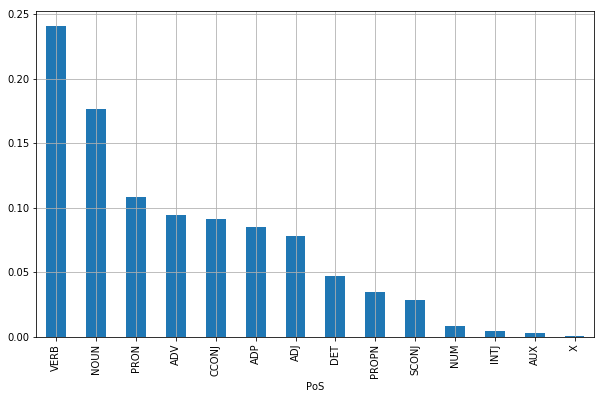

In [86]:
pos_plot(got_train_stat)

## Gothic Pos-Tag Statistic (test)

In [87]:
got_test_stat = pos_stat(got_test_tag_count)
got_test_stat

,PoS,Count,CountNormalize
8,VERB,7913,0.225931
1,NOUN,6618,0.188956
7,PRON,3547,0.101273
0,ADV,3276,0.093536
11,CCONJ,3204,0.091480
2,ADP,3139,0.089624
13,ADJ,3114,0.088910
5,DET,1527,0.043599
4,PROPN,1185,0.033834
3,SCONJ,1059,0.030236


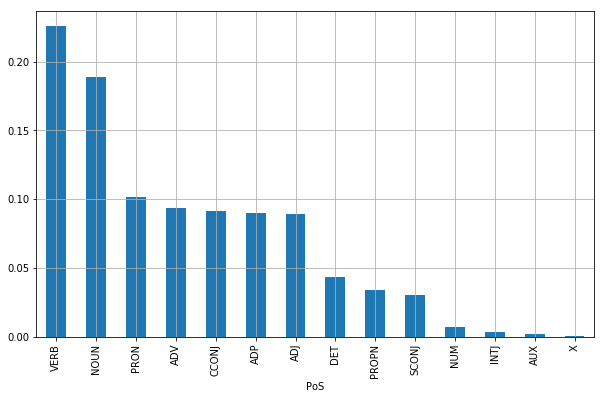

In [88]:
pos_plot(got_test_stat)

## Gothic Binary attribute Statistic (train)

  Attribute  Count      Norm
0    Reflex    111  0.371237
1      Poss    188  0.628763


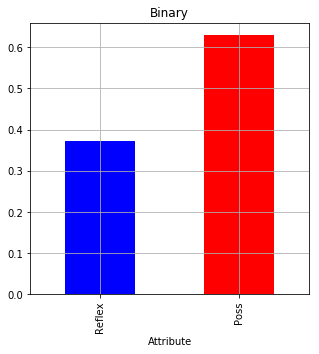

In [89]:
binary_attr_plot(got_train_attr_count)

## Gothic Binary attribute Statistic (test)

  Attribute  Count      Norm
0    Reflex    281  0.282696
1      Poss    713  0.717304


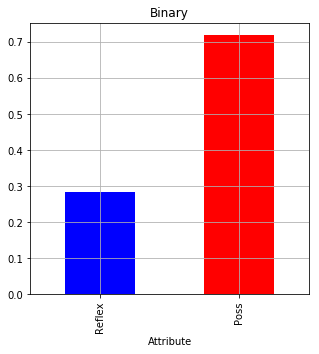

In [90]:
binary_attr_plot(got_test_attr_count)

## Gothic Categorical attribute Statistic (train)

Case
  Attribute  Count      Norm
0       Dat   1338  0.260717
1       Acc   1375  0.267927
2       Voc     68  0.013250
3       Gen    586  0.114186
4       Nom   1765  0.343920


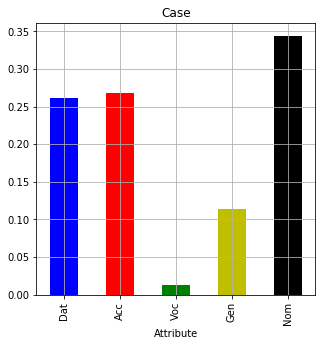

Mood
  Attribute  Count      Norm
0       Ind   1432  0.820160
1       Imp     89  0.050974
2       Opt    225  0.128866


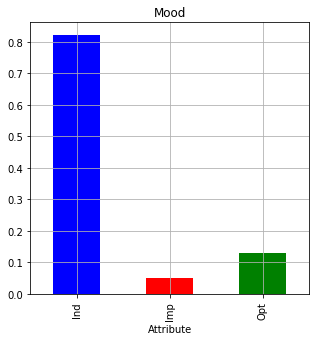

Degree
  Attribute  Count      Norm
0       Cmp     18  0.048257
1       Pos    330  0.884718
2       Sup     25  0.067024


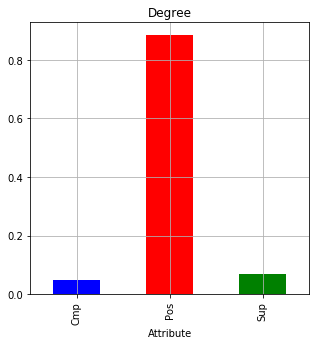

Gender
   Attribute  Count      Norm
0       Neut    782  0.153273
1  Masc,Neut     72  0.014112
2        Fem    903  0.176989
3       Masc   3271  0.641121
4   Fem,Masc     74  0.014504


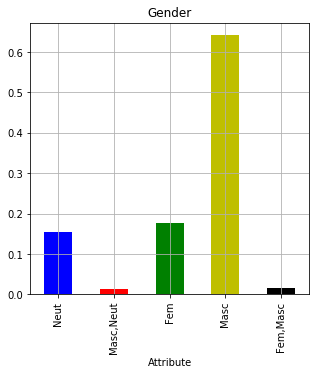

Number
  Attribute  Count      Norm
0      Sing   2706  0.679217
1      Plur   1273  0.319528
2      Dual      5  0.001255


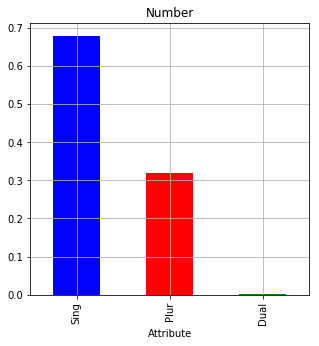

Person
  Attribute  Count      Norm
0         1    435  0.154639
1         3   1849  0.657305
2         2    529  0.188055


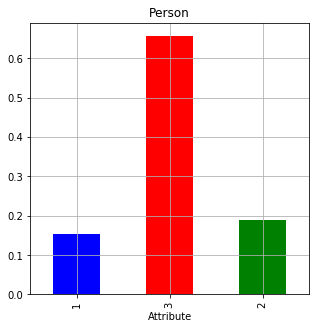

Tense
  Attribute  Count      Norm
0      Past   1068  0.435741
1      Pres   1383  0.564259


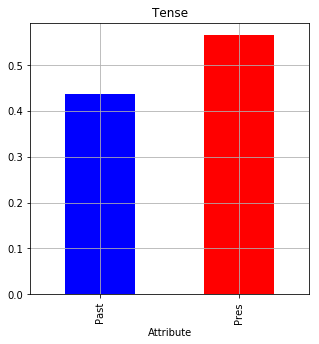

VerbForm
  Attribute  Count      Norm
0       Inf    160  0.065279
1      Part    545  0.222358
2       Fin   1746  0.712362


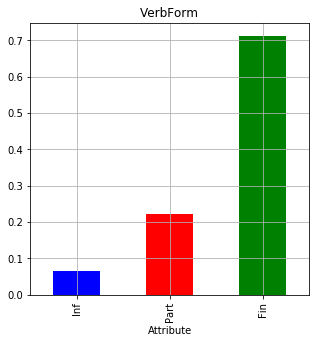

In [91]:
categorical_attr_plot(got_train_attr_count)

## Gothic Categorical attribute Statistic (test)

Case
  Attribute  Count      Norm
0       Dat   4907  0.276264
1       Acc   4375  0.246312
2       Voc    127  0.007150
3       Gen   2423  0.136415
4       Nom   5930  0.333859


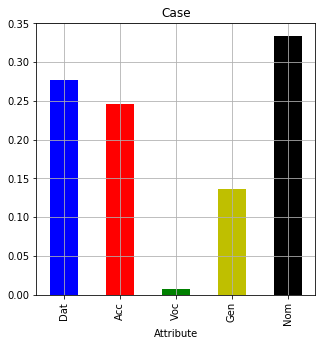

Mood
  Attribute  Count      Norm
0       Ind   4581  0.796557
1       Imp    283  0.049209
2       Opt    887  0.154234


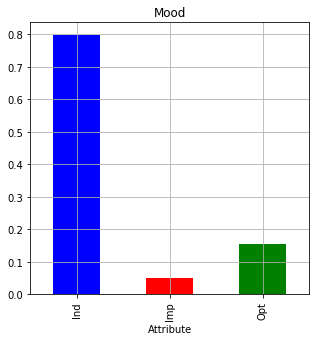

Degree
  Attribute  Count      Norm
0       Sup     78  0.050032
1       Pos   1408  0.903143
2       Cmp     73  0.046825


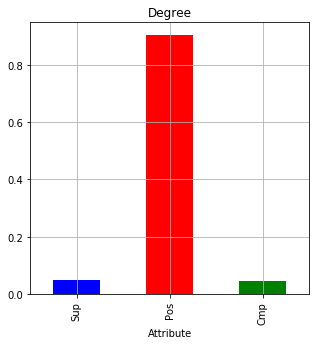

Gender
   Attribute  Count      Norm
0   Fem,Masc    223  0.012730
1        Fem   3494  0.199463
2   Fem,Neut      4  0.000228
3  Masc,Neut    421  0.024034
4       Neut   2903  0.165725
5       Masc  10472  0.597819


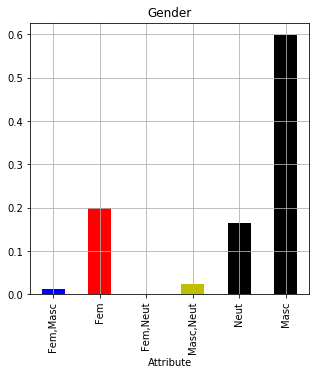

Number
  Attribute  Count      Norm
0      Sing   8530  0.644649
1      Plur   4669  0.352857
2      Dual     33  0.002494


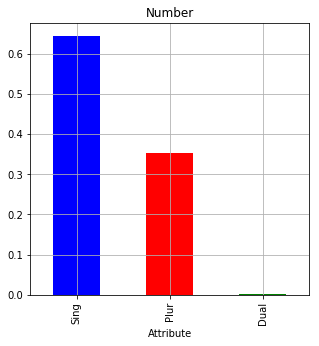

Person
  Attribute  Count      Norm
0         1   2041  0.220125
1         3   5110  0.551122
2         2   2121  0.228753


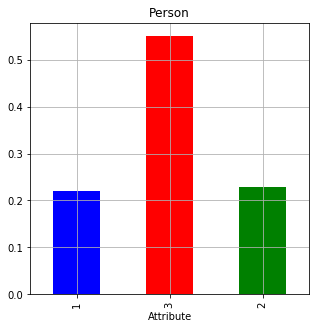

Tense
  Attribute  Count      Norm
0      Past   2738  0.346013
1      Pres   5175  0.653987


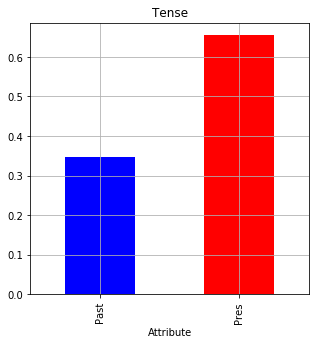

VerbForm
  Attribute  Count      Norm
0       Inf    552  0.069759
1      Part   1610  0.203463
2       Fin   5751  0.726779


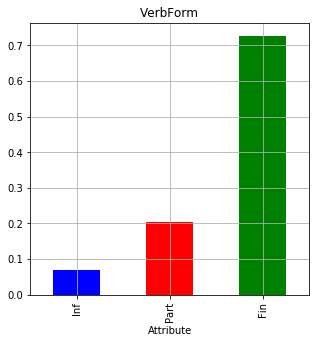

In [92]:
categorical_attr_plot(got_test_attr_count)

## Gothic Universal Dependency Statistic (train)

In [93]:
got_train_dep = universal_dep_stat(got_train_dep_count)
got_train_dep

,Dep,Count,Norm
30,root,1028,0.100962
1,cc,906,0.088981
17,nsubj,857,0.084168
16,case,834,0.081909
23,obl,774,0.076016
8,obj:dir,753,0.073954
19,advmod,685,0.067276
25,det,574,0.056374
5,conj,572,0.056178
26,nmod,561,0.055097


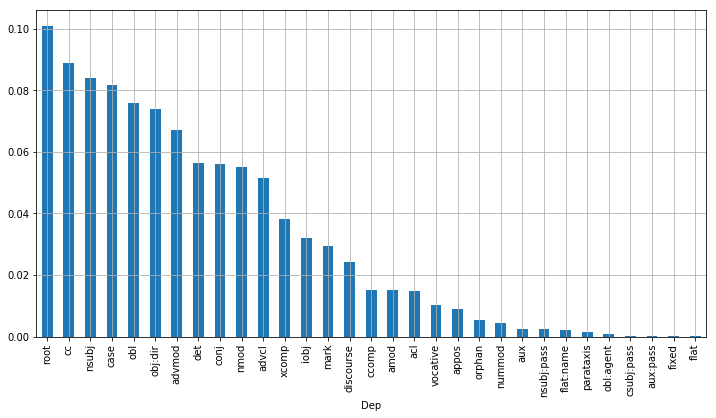

In [94]:
universal_dep_plot(got_train_dep)

## Gothic Universal Dependency Statistic (test)

In [95]:
got_test_dep = universal_dep_stat(got_test_dep_count)
got_test_dep

,Dep,Count,Norm
30,root,3387,0.096705
1,cc,3150,0.089938
22,case,3051,0.087112
17,nsubj,2792,0.079717
23,obl,2651,0.075691
19,advmod,2519,0.071922
8,obj:dir,2334,0.066640
27,nmod,2243,0.064042
5,conj,2110,0.060244
26,det,1851,0.052849


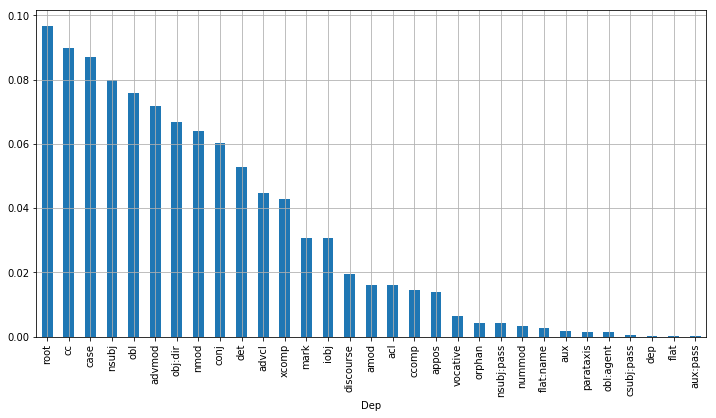

In [96]:
universal_dep_plot(got_test_dep)

# Задание №2 

In [99]:
def parse_deps(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        deps = []
        sentence = {}
        for line in lines:
            line = line.strip().split(TAB_CHAR)
            if line[0].isdigit():
                if int(line[0]) == 1:
                    if sentence:
                        deps.append(sentence)
                    sentence = {}
                if int(line[6]) in sentence:
                    sentence[int(line[6])].append(int(line[0]))
                else:
                    sentence[int(line[6])] = [int(line[0])]
        return deps

    
def is_projective(deps, word_id, lb, ub):
    if word_id < lb or word_id > ub:
        return False
    if word_id in deps.keys():
        for word in deps[word_id]:
            if word < word_id:
                return is_projective(deps, word, lb, min(ub, word_id))
            else:
                return is_projective(deps, word, max(lb, word_id), ub)
    return True


def get_non_projective_sents_id(filepath):
    deps = parse_deps(filepath)
    sentences = []
    for i in xrange(len(deps)):
        if not is_projective(deps[i], 0, -1, float("inf")):
            sentences.append(i)
    return sentences, len(deps)

def get_all_sentences(filepath):
    with open(filepath) as f:
        lines = f.readlines()
        res = list()
        ids = list()
        for line in lines:
            if line.startswith("# sent_id = "):
                ids.append(line.replace("# sent_id = ","")[:-1])
            if line.startswith("# text ="):
                res.append(line.replace("# text = ", ""))
        return res, ids

## English projective trees train

In [102]:
en_pos_filename = '/output/eng-with-tagger.conll'
en_without_pos_filename = '/output/eng-wo-tagger.conll'

en_non_projective, all_deps_count = get_non_projective_sents_id(en_pos_filename)
print('With SyntaxNet PoS-tagger:')
print('Projective count: {}'.format(all_deps_count - len(en_non_projective)))
print('Non-projective count: {}'.format(len(en_non_projective)))

en_non_projective, all_deps_count = get_non_projective_sents_id(en_without_pos_filename)
print('Without PoS-tagger:')
print('Projective count: {}'.format(all_deps_count - len(en_non_projective)))
print('Non-projective count: {}'.format(len(en_non_projective)))

With SyntaxNet PoS-tagger:
Projective count: 2076
Non-projective count: 0
Without PoS-tagger:
Projective count: 2076
Non-projective count: 0


## English projective trees test

In [105]:
en_test_filename ='/data/UD_English/en-ud-test.conllu'
en_test_non_projective, all_deps_count = get_non_projective_sents_id(en_test_filename)
print('Projective count: {}'.format(all_deps_count - len(en_test_non_projective)))
print('Non-projective count: {}'.format(len(en_test_non_projective)))
print('Non-projective sentences:')
en_test_sentences, en_sents_ids = get_all_sentences(en_test_filename)
for i in en_test_non_projective:
    print('Sentence id: {}, sentence text: {}'.format(en_sents_ids[i], en_test_sentences[i]))

Projective count: 2065
Non-projective count: 11
Non-projective sentences:
Sentence id: email-enronsent36_01-0005, sentence text: Team, sorry for the delay on getting this around.

Sentence id: newsgroup-groups.google.com_HumorUniversity_00dd93cc9545deb3_ENG_20051130_122700-0004, sentence text: Good Morning* *

Sentence id: newsgroup-groups.google.com_alt.animals.cat_003362349f033873_ENG_20040712_077100-0014, sentence text: -----= Posted via Newsfeeds.Com, Uncensored Usenet News =-----

Sentence id: answers-20090801154222AA09uXV_ans-0001, sentence text: Which do you prefer Crab or Shrimp?

Sentence id: answers-20111106022931AAwpqXm_ans-0001, sentence text: NZers: Have you decided who you're going to vote for?

Sentence id: reviews-283903-0002, sentence text: quick in & out.

Sentence id: reviews-363428-0004, sentence text: Nothing too much trouble for Ian, thanks for a great stay.

Sentence id: reviews-329807-0004, sentence text: Highly recommended.

Sentence id: reviews-374344-0003, se

## Gothic projective trees train

In [104]:
got_pos_filename = '/output/go-with-tagger.conll'
got_without_pos_filename = '/output/go-wo-tagger.conll'

got_non_projective, all_deps_count = get_non_projective_sents_id(got_pos_filename)
print('With SyntaxNet PoS-tagger:')
print('Projective count: {}'.format(all_deps_count - len(got_non_projective)))
print('Non-projective count: {}'.format(len(got_non_projective)))

got_non_projective, all_deps_count = get_non_projective_sents_id(got_without_pos_filename)
print('Without PoS-tagger:')
print('Projective count: {}'.format(all_deps_count - len(got_non_projective)))
print('Non-projective count: {}'.format(len(got_non_projective)))

With SyntaxNet PoS-tagger:
Projective count: 1027
Non-projective count: 0
Without PoS-tagger:
Projective count: 1027
Non-projective count: 0


## Gothic projective trees test

In [107]:
got_test_filename ='/data/UD_English/en-ud-test.conllu'
got_test_non_projective, all_deps_count = get_non_projective_sents_id(got_test_filename)
print('Projective count: {}'.format(all_deps_count - len(got_test_non_projective)))
print('Non-projective count: {}'.format(len(got_test_non_projective)))
print('Non-projective sentences:')
got_test_sentences, got_sents_ids = get_all_sentences(got_test_filename)
for i in got_test_non_projective:
    print('Sentence id: {}, sentence text: {}'.format(got_sents_ids[i], got_test_sentences[i]))

Projective count: 2065
Non-projective count: 11
Non-projective sentences:
Sentence id: email-enronsent36_01-0005, sentence text: Team, sorry for the delay on getting this around.

Sentence id: newsgroup-groups.google.com_HumorUniversity_00dd93cc9545deb3_ENG_20051130_122700-0004, sentence text: Good Morning* *

Sentence id: newsgroup-groups.google.com_alt.animals.cat_003362349f033873_ENG_20040712_077100-0014, sentence text: -----= Posted via Newsfeeds.Com, Uncensored Usenet News =-----

Sentence id: answers-20090801154222AA09uXV_ans-0001, sentence text: Which do you prefer Crab or Shrimp?

Sentence id: answers-20111106022931AAwpqXm_ans-0001, sentence text: NZers: Have you decided who you're going to vote for?

Sentence id: reviews-283903-0002, sentence text: quick in & out.

Sentence id: reviews-363428-0004, sentence text: Nothing too much trouble for Ian, thanks for a great stay.

Sentence id: reviews-329807-0004, sentence text: Highly recommended.

Sentence id: reviews-374344-0003, se

Можно сделать вывод, что для предложений, в которых не выполняется свойство проективности, SyntaxNet строит деревья неправильно. 